# Solving linear equation with Feynmann-Kac

In [28]:
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

import matplotlib.font_manager as font_manager
import matplotlib.patches as patches
font = font_manager.FontProperties(style='normal', size=20)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_default_dtype(torch.float32) # improved the speed when the parameters are float32
import random

import json

from IPython.display import display, Math, Markdown

import datetime
import os
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
timestamp
version = '_0.1.0'
import math
PI = math.pi

# Wiener process

$$\begin{cases}
V_t+\frac{1}{2}\Delta V + C(x) = 0\\
V(T,x)=g(x)\end{cases}$$

Approximate $V(0,0)$ when $C(x)= \begin{cases}1-|x|&x\in[-1,1]\\ 0& \text{otherwise}\end{cases}$ and $g(x)=1\!\!1_{[-1,1]}$



$$V(0,x)=\mathbb{E}\left[\int_0^T C(X_r){{dr}}+g(X_T)\Big|X_0=x\right]\approx\frac{1}{J}\Big(\sum_{n=0}^{N-1} C(\hat{X}_{t_n}^j)\Delta t+g(\hat{X}_T^j)\Big)$$


Take $T=1$



## First do the approximation for $x=0$

In [34]:
N = 100 # number of time steps
T = .1 # terminal time
dt = T/N # time step
num_samples = 10_000 # Modify the number of samples
# x0 = 2*torch.rand([num_samples,1]) -1 # initial condition uniformly random in [-1,1]
dW = torch.sqrt(torch.tensor(dt))*torch.randn([num_samples,N+1,1]) # Brownian increments
dW[:,0,:]=0.0 # first increment is zero
W = torch.cumsum(dW, dim=1) # Wiener process paths

def running_cost(x):
    return torch.max(torch.zeros_like(x), 1 - torch.abs(x))*dt

def terminal_cost(x):
    y = torch.zeros_like(x)
    for i in range(x.shape[0]):
        if x[i]<1 and x[i]>-1:
            y[i]=1
    return y

In [35]:
def fk_eval(x):
    return torch.mean(torch.sum(running_cost(x+W[:,:-1,:]), dim=1) + terminal_cost(x+W[:,-1,:]))

In [36]:
fk_eval(torch.Tensor([0.]))

tensor(1.0818)

## Next do the approximation for $t=0$ at $x\in[-10,10]$

# Dirty quick job

In [ ]:
x = torch.linspace(-10,10,1000)
y = torch.zeros_like(x)
for i in range(x.shape[0]):
    y[i] = fk_eval(x[i].reshape(1,1))
    

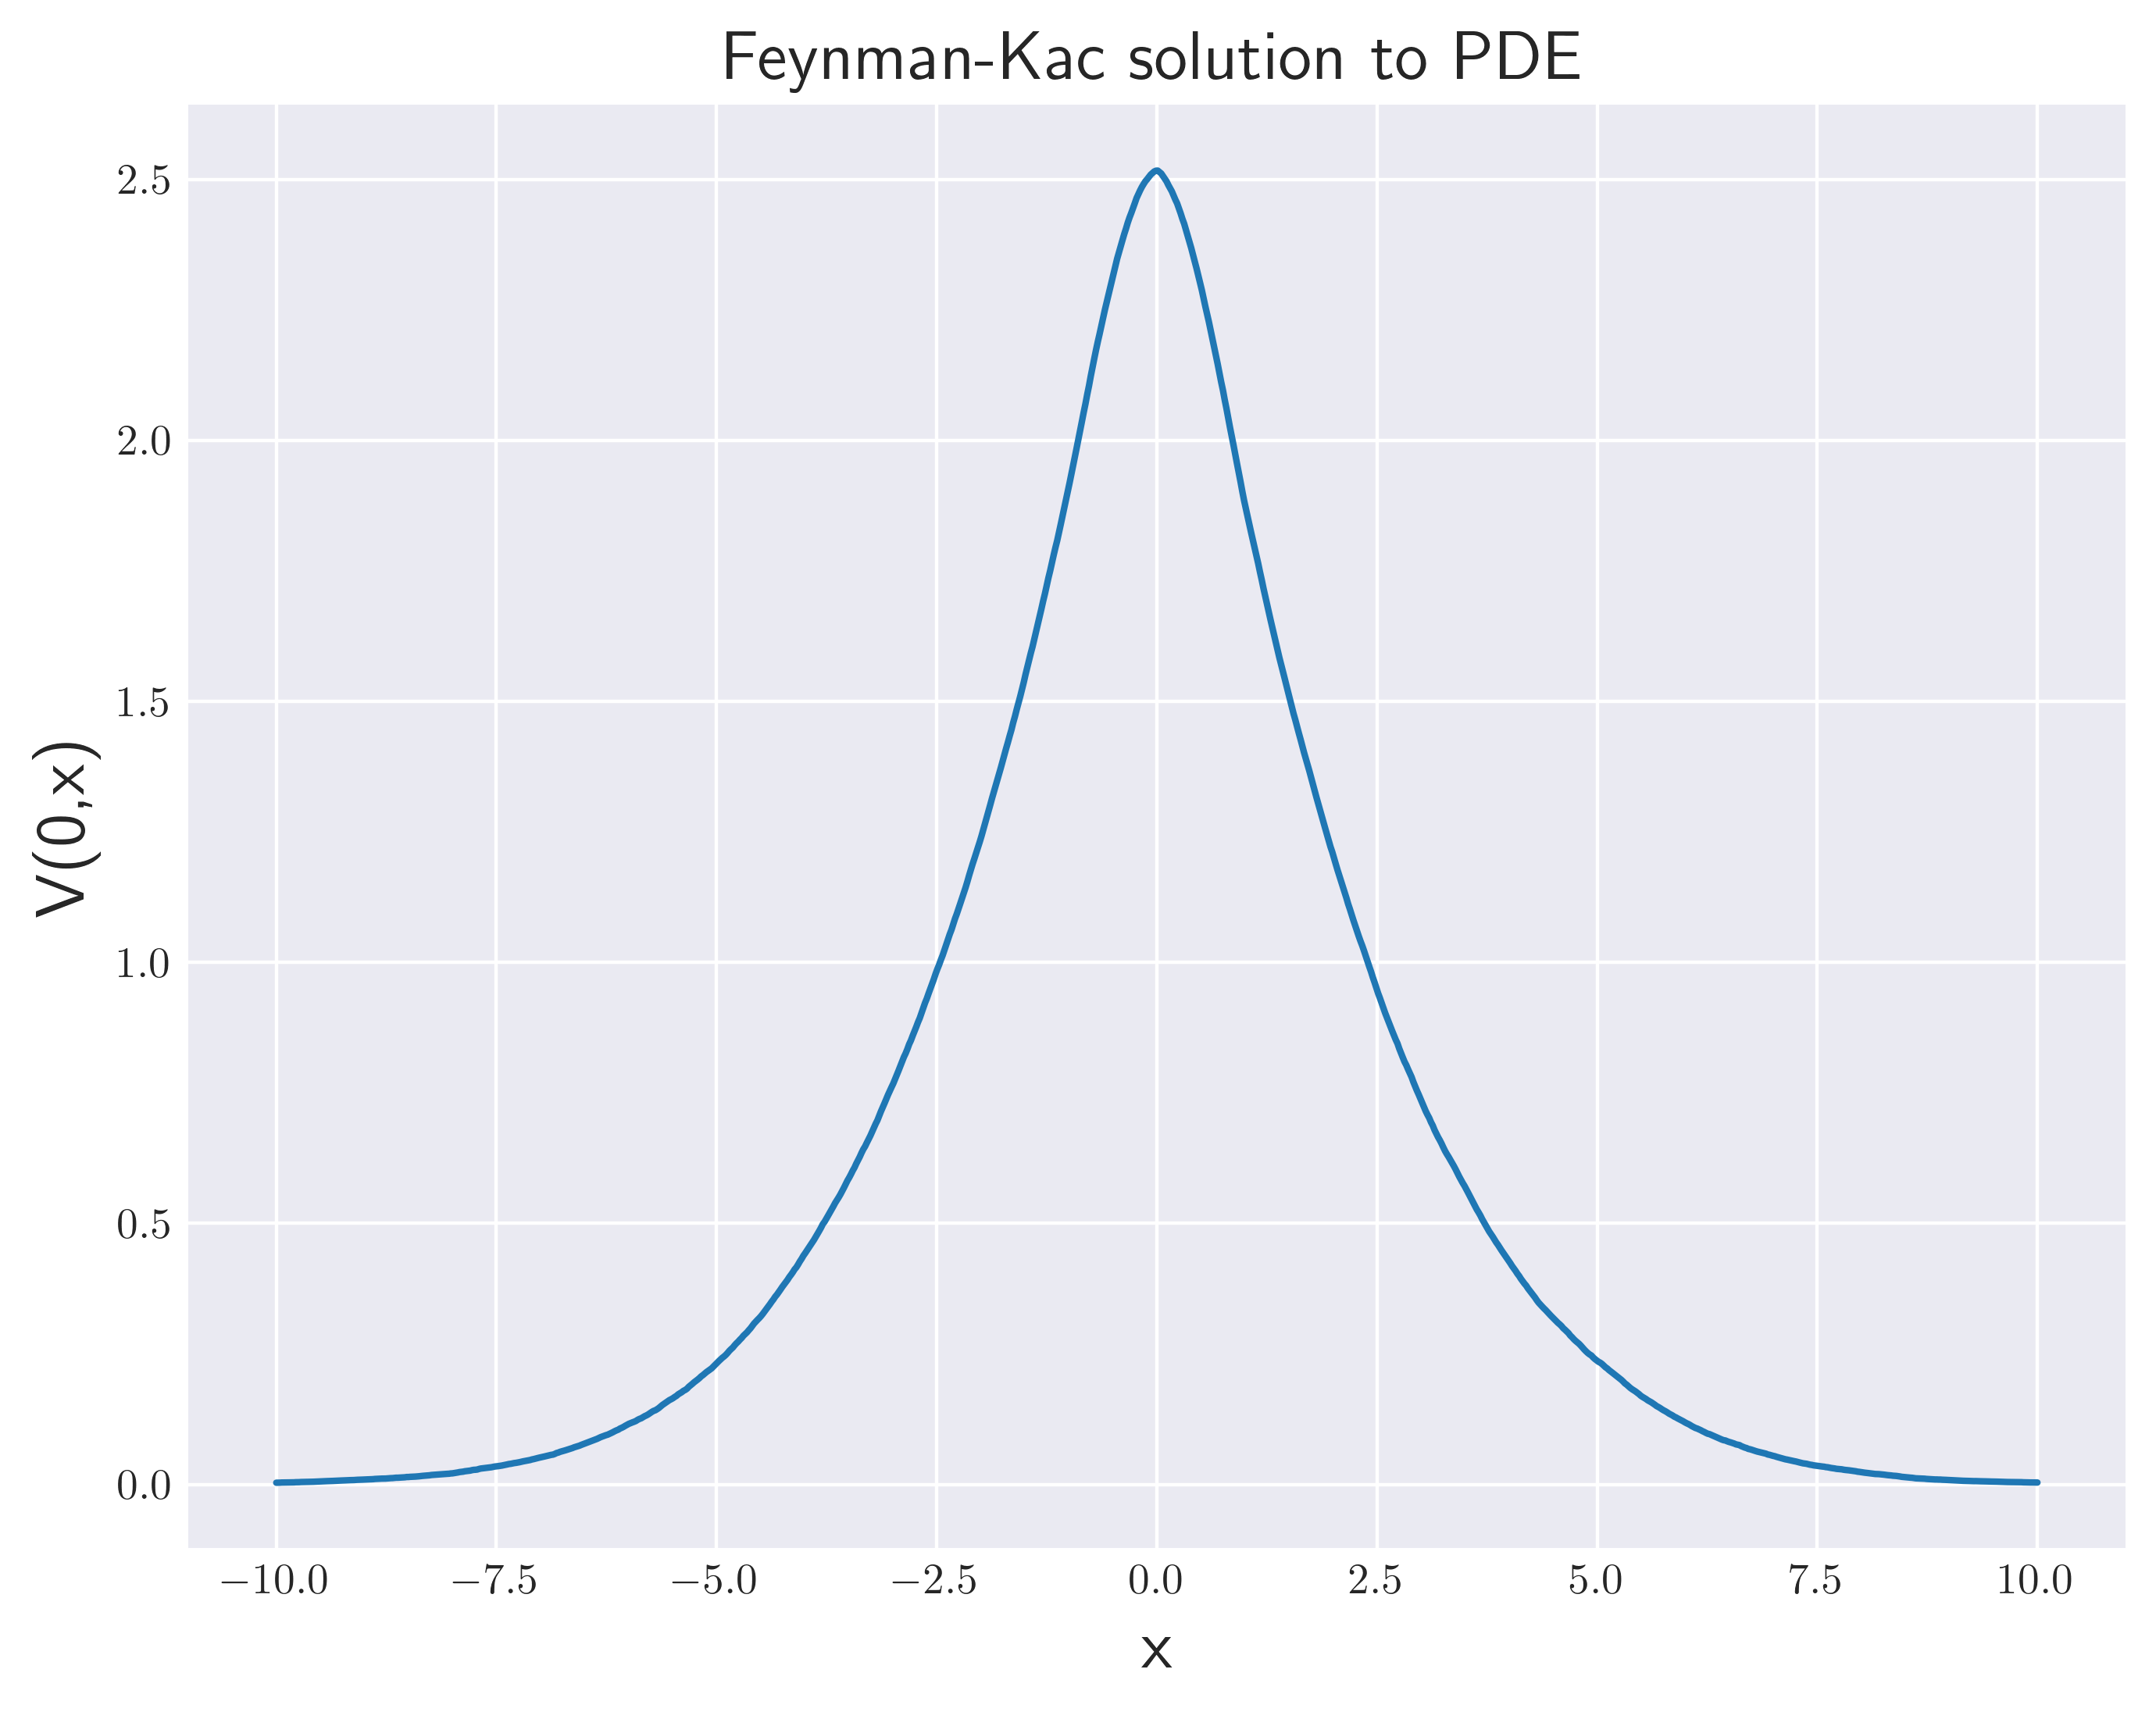

In [ ]:
f = plt.figure(figsize=(8,6), dpi=400)
plt.plot(x.numpy(), y.numpy(), label='Feynman-Kac solution', color='blue')
plt.plot(x.numpy(), terminal_cost(x).numpy(), '--', label='Terminal cost', color='orange')
plt.xlabel('x', fontsize=16)
plt.ylabel('V(0,x)', fontsize=16)
# plt.title('Feynman-Kac solution to PDE', fontsize=16);

## Neural network approximation



In [ ]:
num_neurons = 10 # Modify the number of neurons

model = torch.nn.Sequential(
            torch.nn.Linear(1, num_neurons),
            torch.nn.ReLU(),
            torch.nn.Linear(num_neurons,1),
        )